# Model Error due to Discretization and Aliasing

This notebook continues on to demonstrate the effects of discretization and aliasing on a few simpler examples than the work I've been doing with Noddy, in order to break down the effects in more detail.  I'm keeping it in order to make my incremental work more visible to my colleagues.

The BlockWorlds utilities I'm developing for this will be modularized in a way that mirrors the conceptual siloing between geology, geophysics, and data science.  They're meant to emulate the kinds of issues we'll find across a range of 3-D geological models, including Noddy and GemPy, in a package that runs quickly and can be picked apart for interrogation.

The likelihood for the kind of inverse problem I'm looking at has the general form $P(y|\theta) = P(y|f(g(\theta))) = \mathcal{L}(\theta)$, where
* $\theta \in \Theta$ is a vector of geologically interpretable parameters, such as the depth to an interface or the dip of a fault plane
* $y \in \mathcal{Y} $ are sensor data, for example from a potential-field sensor such as gravity or magnetic anomaly
* $g\!: \Theta \rightarrow \mathcal{G}$ is a mapping from the geological parameter space to a space $\mathcal{G} \sim \mathbf{R}^3 \times \mathbf{R}^n$ of idealized geological block models, each one defined as a collection of rock properties (scalar, vector, or tensor fields) varying over 3-D space $\mathbf{R}^3$
* $f\!: \mathcal{G} \rightarrow \mathcal{Y}$ is a mapping from the space of geological block models to the space of synthetic sensor datasets, defining the forward action of a sensor

Real-world computers usually can't resolve the idealized block model, approximating it instead by some discretized version $g_\Delta\!: \Theta \rightarrow \mathcal{G}_\Delta$.  The sensor forward model is also approximated by a discretized version $f_\Delta\!: \mathcal{G}_\Delta \rightarrow \mathcal{Y}$.  The question we're concerned here is how closely the composition $f_{\Delta} \circ g_{\Delta}$ approximates the true underlying map $f \circ g$ from geological parameters to data as a function of the partition $\Delta$ of $\mathbf{R}^3$, and how to quantify the uncertainty induced by discretization into the likelihood.

This approach to inference constitutes a fusion of geology and geophysics.  Conventional geophysical inversions include the discrete action of the sensor forward model $f_\Delta$, but don't have a separate interpretable parameter space $\Theta$; the parameters of such an inversion are a discrete, voxelized field of rock properties $g(\mathbf{x})$.  While such a world is discontinuous at the voxel level, the model usually amounts to a linear regression on those rock properties and hence is well-behaved (smooth, convex for most likelihoods, etc.).  These posteriors are then interpreted separately by a geologist; in fact this is how many first-pass geological maps are made.  The additional map from interpretable parameters to block model takes over, in a limited scope, the action of the geologist, by proposing an interpretation for the rock properties.  As we'll see, this creates some challenges for a Bayesian approach:  unquantified model error in the discretization ends up inducing artefacts on the posterior $P(\theta | y)$ that may impede the performance of MCMC algorithms.

## Synthetic case:  a sphere of uniform density

We'll start with the gravitational field from a sphere of mass density contrast $\rho$ and radius $R$ centered at a point $\mathbf{r_0}$, which can be calculated analytically based on Gauss's law applied to the inverse-square force law of gravity (it's a standard undergraduate physics problem):

$$g(\mathbf{r}) = -\frac{GM}{|\mathbf{r - r_0}|^2} = -\frac{4\pi G \rho R^3}{3 |\mathbf{r - r_0}|^2}$$

for $|\mathbf{r - r_0}| > R$.  Note that if we're trying to infer $R$, $\rho$, and $\mathbf{r_0}$, there is a degeneracy along the locus $\rho = M/R^3$.  Taking measurements inside the sphere would in theory resolve the degeneracy, but apart from the fact that we don't always (or even usually) have ground truth measurements from boreholes in these kinds of problems, the presence of a mode along a curved submanifold presents a benchmark challenge for sampling that I'll look into below.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from blockworlds import DiscreteGravity, baseline_tensor_mesh
from blockworlds import survey_gridded_locations, analytic_forward_gravity_sphere, plot_gravity
from blockworlds import profile_timer

# True sphere properties
R_0, rho_0 = 10.0, 5.0
def gfunc_uniform_sphere(r, R, rho):
    return rho * (np.sum(r**2, axis=1) < R**2)

# Instantiate a basic rectilinear "tensor mesh",
# and a grid-like survey of 100 observations at the surface
L, h = 16.0, 2.0
Nh = 2*int(L/h)
mesh = baseline_tensor_mesh(Nh, h)
survey_10x10 = survey_gridded_locations(L, L, 10, 10, L, ['gz'])

# Instantiate the forward model and cache its sensitivities
fwdmodel = profile_timer(DiscreteGravity, mesh, survey_10x10, gfunc_uniform_sphere)
data = profile_timer(fwdmodel.calc_gravity, R_0, rho_0)

DiscreteGravity ran in 0.004 sec
calc_gravity ran in 0.325 sec


calc_gravity ran in 0.002 sec


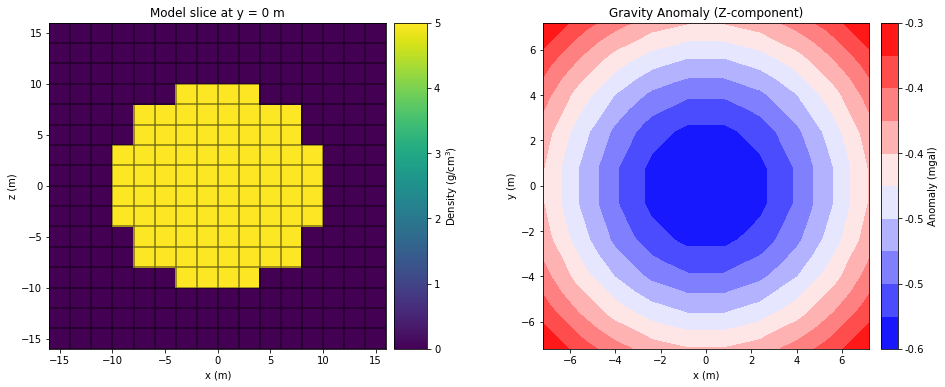

In [2]:
# Run the forward model for the true parameters
R_0 = 10
data = profile_timer(fwdmodel.calc_gravity, R_0, rho_0)
# These quick methods plot whatever gravity signal was last calculated
fig1 = plt.figure(figsize=(16,6))
ax1 = fig1.add_subplot(121)
fwdmodel.plot_model_slice(ax=ax1)
ax2 = fig1.add_subplot(122)
fwdmodel.plot_gravity(ax=ax2)
plt.show()

Although the discretized distribution produces a sphere-like gravity signal, it isn't quite a sphere:

fractional residuals mean, std = -0.00102 0.00791
log L difference (for obs noise of 10.0%) = 31.3


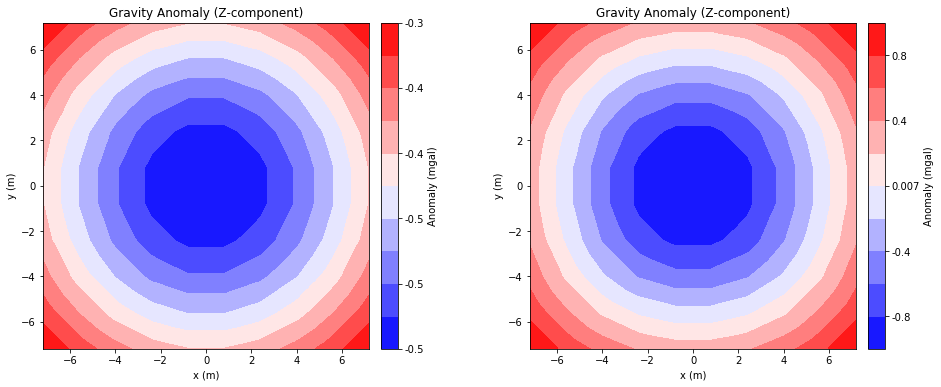

In [3]:
# Calculate analytic forward gravity and its residuals from the discretized version
data0 = analytic_forward_gravity_sphere(survey_10x10, R_0, rho_0, r0=(0,0,0))[2]
resids = data - data0
# In real applications will only be looking at anomaly -- mean signal will be subtracted off
resids -= resids.mean()
# Make measurement error a fraction of the full scale of the data, say 10%
sigrel = 0.1
sigdata = sigrel*np.std(data)
print("fractional residuals mean, std = {:.3g} {:.3g}".format((resids/data0).mean(), (resids/data0).std()))
print("log L difference (for obs noise of {:.1f}%) = {:.3g}".format(100*sigrel, np.sum((resids/sigdata)**2)))
# Plot the results
fig2 = plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
plot_gravity(survey_10x10, data0, ax=ax1)
ax2 = plt.subplot(122)
plot_gravity(survey_10x10, resids/sigdata, ax=ax2)
plt.show()

The inaccuracy may not look like much at first, but it amounts to 10% of the noise error, which takes its toll when there are 100 points in the survey.  The good news is that, at least on the surface, the error in the data seems smooth and well-approximated by a smooth function like a Gaussian process.  We might therefore expect existing model calibration frameworks, such as Kennedy & O'Hagan (2001), to work reasonably well.  The question in my mind is whether we can do any better by opening the black box, or by using some limited knowledge of what's inside the box to make smarter estimates of the model inadequacy arising specifically from the discretization step.

Just for fun, let's try a scan across the likelihood now, in the two variables $\rho$ and $R$:

In [4]:
def log_likelihood(data, dpred, sigma):
    # Independent Gaussian for sake of argument
    resids = data - dpred
    resids -= resids.mean()
    return -0.5*np.sum(resids**2/sigma**2 + np.log(2*np.pi*sigma**2))

def run_grid(dsynth, rho_vals, R_vals, calc_gravity):
    grid_vals = [ ]
    for rho in rho_vals:
        for R in R_vals:
            dpred = calc_gravity(R, rho)
            grid_vals.append([rho, R, log_likelihood(dpred, dsynth, sigdata)])
    grid_vals = np.array(grid_vals).T.reshape(3, len(rho_vals), len(R_vals))
    return grid_vals

def show_contours(xg, yg, Lg, rho_vals, R_vals, rho_0, R_0):
    levels = 10**np.arange(-6,0.1)
    levels = np.log(10)*np.arange(-6,0.1)
    # plt.contourf(xg, yg, np.exp(Lg - Lg.max()), levels=levels)
    plt.contourf(xg, yg, Lg - Lg.max(), levels=levels)
    plt.plot(rho_vals, R_vals, ls='--', lw=2, color='red')
    plt.plot(rho_0, R_0, marker='+', ms=15, mew=3, color='red')
    plt.colorbar()
    ax1.set_xlim(rho_vals.min(), rho_vals.max())
    ax1.set_ylim(R_vals.min(), R_vals.max())

run_grid ran in 1.523 sec
run_grid ran in 0.174 sec


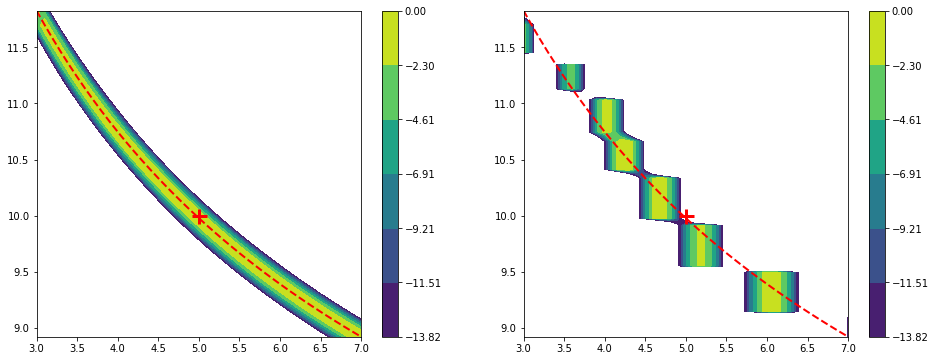

In [5]:
epsilon = sigdata*np.random.normal(size=data0.shape)
dsynth = data0 + epsilon

M = 4.0*np.pi/3.0 * rho_0 * R_0**3
rho2R = lambda rho: (0.75*M/(np.pi*rho_vals))**0.333

# Run the grid
rho_vals = np.arange(rho_0 - 2.0, rho_0 + 2.01, 0.1)
R_vals = rho2R(rho_vals)
xg, yg, Lg = profile_timer(run_grid, dsynth, rho_vals, R_vals,
                           fwdmodel.calc_gravity)
xg, yg, Lg0 = profile_timer(run_grid, dsynth, rho_vals, R_vals,
                            lambda R, rho: analytic_forward_gravity_sphere(fwdmodel.survey, R, rho, r0=(0,0,0))[2])

# Show two views, as in the other notebook
fig3 = plt.figure(figsize=(16,6))
# First, on left, is a contour plot of the analytic posterior
# Indicate the locus of equal mass for the sphere, and the true solution
ax1 = plt.subplot(121)
show_contours(xg, yg, Lg0, rho_vals, R_vals, rho_0, R_0)
# Second, on right, is a plot of the navigable area including the true value
ax2 = plt.subplot(122)
show_contours(xg, yg, Lg, rho_vals, R_vals, rho_0, R_0)
# Show both plots
plt.show()

The posterior contours are drawn on a log scale, with a factor of 10 in probability density between each contour level, and the lowest level at a density of $10^{-6}$ relative to the mode.  This emphasizes the regions that are likely to be navigable by an optimizer or MCMC sampler that arrives at a mode.  The red dashed line corresponds to the locus of degeneracy $\frac{4}{3} \pi \rho R^3 = M$ in the analytic solution, and the red cross marks the true parameters used to generate the data.

From this plot we can see that the discretization has separated the geological likelihood distribution into mutually disjoint islands, even though the underlying _true_ geological likelihood is smooth.  This is because the rock properties in a cell of the block model aren't anti-aliased, or allowed to take on intermediate density values between the two true formations to account for partial true membership in either formation.  As the radius $R$ changes, crossing certain thresholds results in a discontinuous change in membership for voxels near the sphere boundary, which in turn results in a discontinuous change in the predicted gravity measurements, and hence in the likelihood.

Thus the lack of anti-aliasing in the geophysics calculation has *induced* a discontinuous structure on what would otherwise be a smooth posterior.  This makes the difference, in theory, between being able to run Hamiltonian Monte Carlo and having to run a vastly more computationally expensive parallel-tempered scheme, to navigate a multi-modal posterior that is actually a poor approximation to a posterior with only one mode.

And yet _some_ kind of discretization is needed to proceed for problems with no analytic solution, so we'll need to understand how to quantify these effects.  Clearly we'll get a better approximation if we improve our resolution.  What does that cost us?

DiscreteGravity ran in 0.022 sec
calc_gravity ran in 1.869 sec


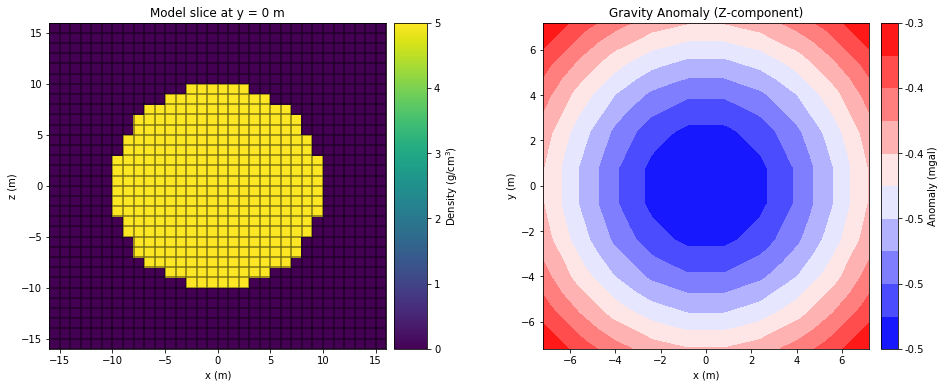

In [6]:
# Instantiate a finer mesh for the same survey
L, h = 16.0, 1.0
Nh = 2*int(L/h)
mesh = baseline_tensor_mesh(Nh, h)

# New forward model
fwdmodel2 = profile_timer(DiscreteGravity, mesh, survey_10x10, gfunc_uniform_sphere)
data2 = profile_timer(fwdmodel2.calc_gravity, R_0, rho_0)
fig4 = plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
fwdmodel2.plot_model_slice(ax=ax1)
ax2 = plt.subplot(122)
fwdmodel2.plot_gravity(ax=ax2)
plt.show()

That's better!  How does it perform?

run_grid ran in 7.140 sec


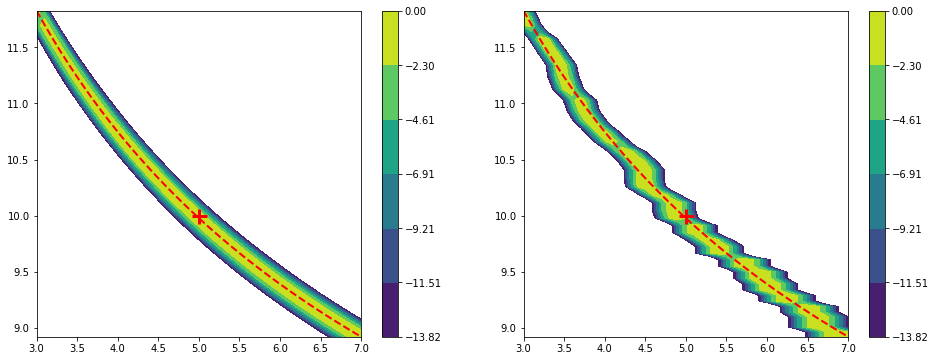

In [7]:
xg, yg, Lg = profile_timer(run_grid, dsynth, rho_vals, R_vals, fwdmodel2.calc_gravity)
fig5 = plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
show_contours(xg, yg, Lg0, rho_vals, R_vals, rho_0, R_0)
ax2 = plt.subplot(122)
show_contours(xg, yg, Lg, rho_vals, R_vals, rho_0, R_0)
plt.show()

This starts to connect the modes up with each other.  Finer still?

DiscreteGravity ran in 0.118 sec
calc_gravity ran in 16.412 sec


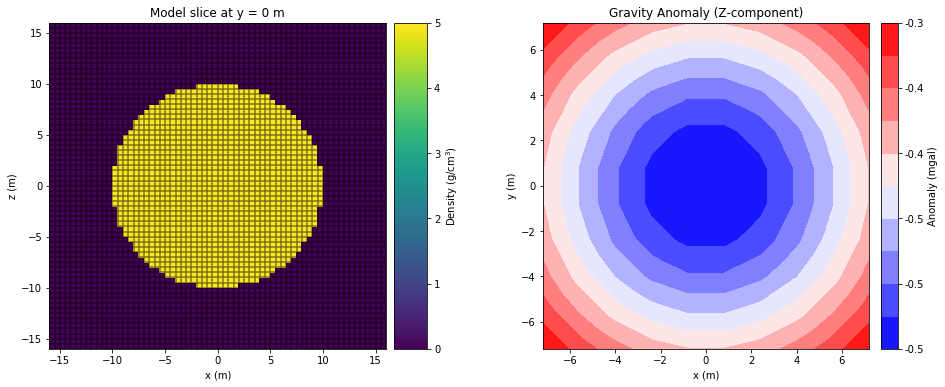

In [8]:
# Instantiate a finer mesh for the same survey
L, h = 16.0, 0.5
Nh = 2*int(L/h)
mesh = baseline_tensor_mesh(Nh, h)

# New forward model
fwdmodel3 = profile_timer(DiscreteGravity, mesh, survey_10x10, gfunc_uniform_sphere)
data3 = profile_timer(fwdmodel3.calc_gravity, R_0, rho_0)
fig6 = plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
fwdmodel3.plot_model_slice(ax=ax1)
ax2 = plt.subplot(122)
fwdmodel3.plot_gravity(ax=ax2)
plt.show()

run_grid ran in 53.208 sec


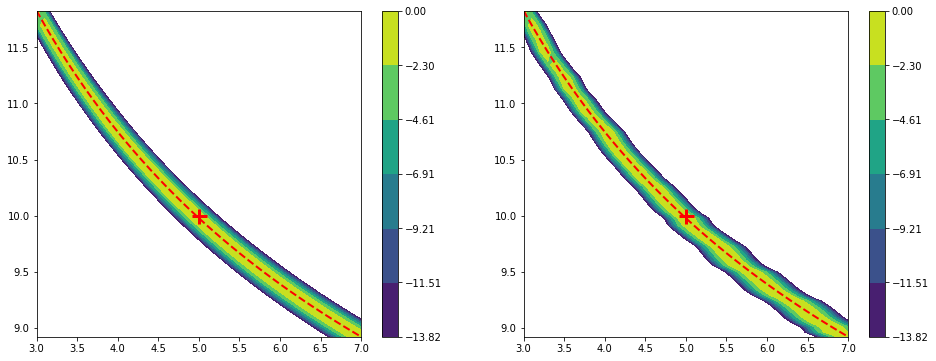

In [9]:
xg, yg, Lg = profile_timer(run_grid, dsynth, rho_vals, R_vals, fwdmodel3.calc_gravity)
fig7 = plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
show_contours(xg, yg, Lg0, rho_vals, R_vals, rho_0, R_0)
ax2 = plt.subplot(122)
show_contours(xg, yg, Lg, rho_vals, R_vals, rho_0, R_0)
plt.show()

This is a much better approximation of the true posterior.  But it's worth noting the cost:  the discrete version at this resolution runs about 50 times slower than the original coarse mesh, and about 400 times slower than the analytic version, even when the sensitivities are cached.  One could address this problem in part by distributing the computation.  Parallelization is a good answer for other important aspects of MCMC, such as running independent chains to assess convergence to the stationary distribution, or running parallel-tempered MCMC sampling.  Ideally, though, we would like each forward model to run as quickly as possible, so that we have the liberty of sampling hundreds of thousands of points to map out the posterior in more dimensions than I have done here.

The other danger of simply running at finer and finer resolution is that the adequacy of the discrete likelihood approximation also depends on the properties of the dataset.  Better data can resolve finer spatial detail, so that a discretization of an area adequate to do inference using one dataset may no longer work for another.  If we change the noise variance and recalculate the model with 1-m blocks, we get this:

calc_gravity ran in 0.006 sec
run_grid ran in 6.398 sec
run_grid ran in 0.126 sec


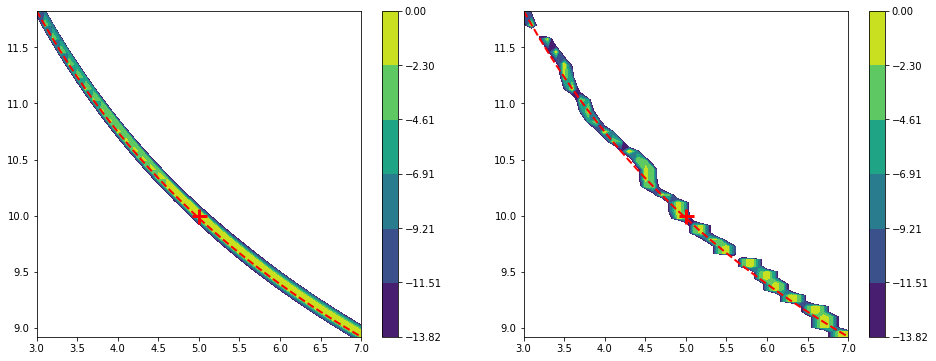

In [10]:
sigrel = 0.05
sigdata = sigrel*np.std(data0)
epsilon = sigdata*np.random.normal(size=dsynth.shape)
dsynth = data0 + epsilon

# New forward model
data4 = profile_timer(fwdmodel2.calc_gravity, R_0, rho_0)
xg, yg, Lg = profile_timer(run_grid, dsynth, rho_vals, R_vals, fwdmodel2.calc_gravity)
xg, yg, Lg0 = profile_timer(run_grid, dsynth, rho_vals, R_vals,
                            lambda R, rho: analytic_forward_gravity_sphere(fwdmodel.survey, R, rho, r0=(0,0,0))[2])
fig8 = plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
show_contours(xg, yg, Lg0, rho_vals, R_vals, rho_0, R_0)
ax2 = plt.subplot(122)
show_contours(xg, yg, Lg, rho_vals, R_vals, rho_0, R_0)
plt.show()

If we instead change the survey density (the number of data points), we get a slower calculation as well as a less accurate likelihood:

DiscreteGravity ran in 0.072 sec
calc_gravity ran in 11.899 sec
run_grid ran in 26.743 sec
run_grid ran in 0.189 sec


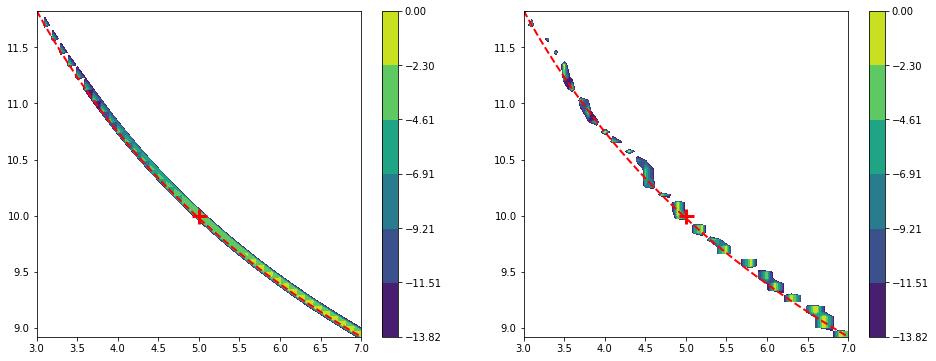

In [11]:
survey_30x30 = survey_gridded_locations(L, L, 30, 30, L, ['gz'])
data0 = analytic_forward_gravity_sphere(survey_30x30, R_0, rho_0, r0=(0,0,0))[2]
sigrel = 0.1
sigdata = sigrel*np.std(data0)
epsilon = sigdata*np.random.normal(size=data0.shape)
dsynth = data0 + epsilon

fwdmodel4 = profile_timer(DiscreteGravity, fwdmodel2.mesh, survey_30x30, gfunc_uniform_sphere)
data4 = profile_timer(fwdmodel4.calc_gravity, R_0, rho_0)
xg, yg, Lg = profile_timer(run_grid, dsynth, rho_vals, R_vals, fwdmodel4.calc_gravity)
xg, yg, Lg0 = profile_timer(run_grid, dsynth, rho_vals, R_vals,
                            lambda R, rho: analytic_forward_gravity_sphere(fwdmodel4.survey, R, rho, r0=(0,0,0))[2])
fig9 = plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
show_contours(xg, yg, Lg0, rho_vals, R_vals, rho_0, R_0)
ax2 = plt.subplot(122)
show_contours(xg, yg, Lg, rho_vals, R_vals, rho_0, R_0)
plt.show()

## Adaptive meshes and anti-aliasing

The regular grids shown above become increasingly inefficient in their use of CPU cycles as the cell size $h$ goes to zero.  The uncertainty in the calculation is concentrated in a thin layer at the boundary of the sphere.  Gridding schemes that take account of the _localization_ of the uncertainty might achieve better accuracy more quickly.  Here's a quick demo of one adaptive mesh type, called an _octree_; it's still a rectilinear grid, but has the option of gaining finer resolution by splitting cells where that resolution is required.  Cell placement and membership is resolved according to a hierarchical tree structure.

/Users/rscalzo/.conda/envs/gempy/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
/Users/rscalzo/.conda/envs/gempy/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


DiscreteGravity ran in 0.011 sec
calc_gravity ran in 0.810 sec


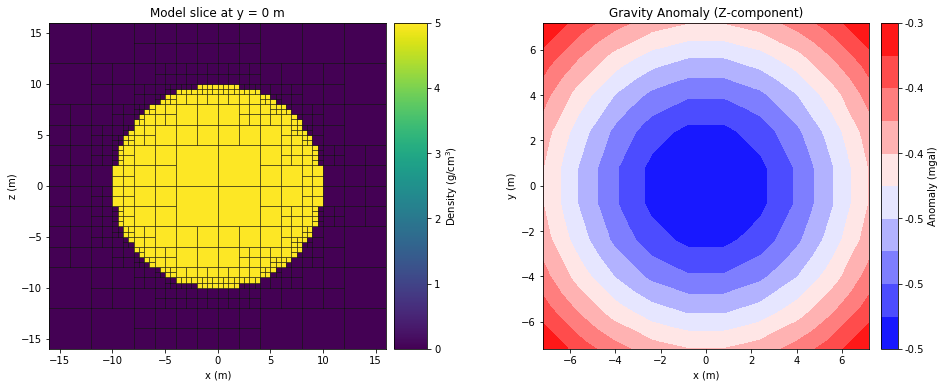

In [12]:
# Produce an octree mesh refined along the sphere border
import blockworlds
from blockworlds import baseline_octree_mesh, refine_octree_surface
L, h = 16.0, 0.5
Nh = 2*int(L/h)
mesh = baseline_octree_mesh(Nh, h)
f = lambda x, y: np.sqrt(R_0**2 - x**2 - y**2)
mesh = refine_octree_surface(mesh, f)
f = lambda x, y: -np.sqrt(R_0**2 - x**2 - y**2)
mesh = refine_octree_surface(mesh, f)
mesh.finalize()

# New forward model
fwdmodel5 = profile_timer(DiscreteGravity, mesh, survey_10x10, gfunc_uniform_sphere)
data4 = profile_timer(fwdmodel5.calc_gravity, R_0, rho_0)
fig8 = plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
fwdmodel5.plot_model_slice(ax=ax1)
ax2 = plt.subplot(122)
fwdmodel5.plot_gravity(ax=ax2)
plt.show()

run_grid ran in 3.289 sec
run_grid ran in 0.159 sec


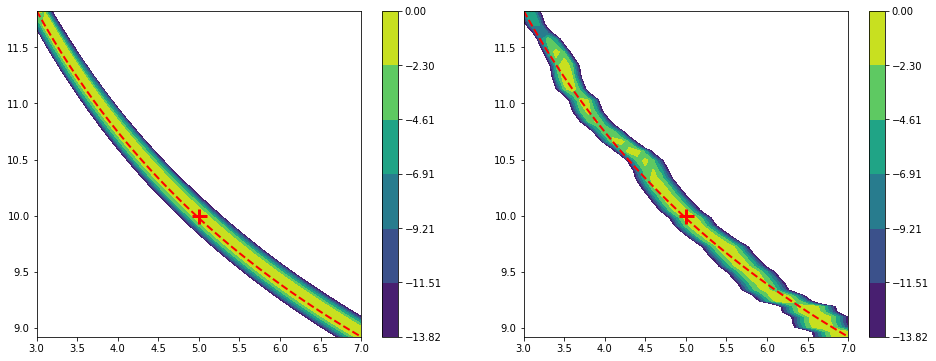

In [13]:
data0 = analytic_forward_gravity_sphere(survey_10x10, R_0, rho_0, r0=(0,0,0))[2]
sigrel = 0.1
sigdata = sigrel*np.std(data0)
epsilon = sigdata*np.random.normal(size=data0.shape)
dsynth = data0 + epsilon

xg, yg, Lg = profile_timer(run_grid, dsynth, rho_vals, R_vals, fwdmodel5.calc_gravity)
xg, yg, Lg0 = profile_timer(run_grid, dsynth, rho_vals, R_vals,
                            lambda R, rho: analytic_forward_gravity_sphere(fwdmodel5.survey, R, rho, r0=(0,0,0))[2])
fig10 = plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
show_contours(xg, yg, Lg0, rho_vals, R_vals, rho_0, R_0)
ax2 = plt.subplot(122)
show_contours(xg, yg, Lg, rho_vals, R_vals, rho_0, R_0)
plt.show()

We're able to achieve now in about 3.6 seconds what took us 60 seconds to achieve before.  The price of this progress is that the grid has now been specialized for a particular set of interfaces, corresponding to a particular set of parameters.  The refinement degrades for cells far from the refined boundary, meaning that we should expect the approximation to be optimal only in a neighborhood of the set of parameters for which we calculated the grid refinement.  The regions of the posterior far from the true values that we used for refinement start to show evidence of discretization error.

To avoid this, we would need to do more:  either update the grid every time we updated the parameters, or use specific prior knowledge about the nature of the parameters to update the grid every time we moved sufficiently far from our original position.  The major advantage of a regular grid is that the forward model sensitivities can be cached and no longer need to be updated for the remainder of the calculation.  We could, of course, couple updates in forward model sensitivities to updates in the grid, but this would require coupling the sensitivity calculation to the grid in an unappealing and labor-intensive way.

In cases where the sensor is a linear filter over the rock properties (gravity falls into this category), _anti-aliasing_ -- in which the rock properties are averaged over the cell before propagating into the model -- can work well.  It also has the advantage that individual discrepant pixels can be addressed without re-mapping the mesh and re-calculating the forward model sensitivities.  However, reducing the uncertainty in rock properties to a _negligible_ level through anti-aliasing probably carries similar cost to doing it through adaptive mesh techniques.  Instead, a probabilistic version of anti-aliasing can be used to quantify uncertainty, and that's the direction we'll look at next.

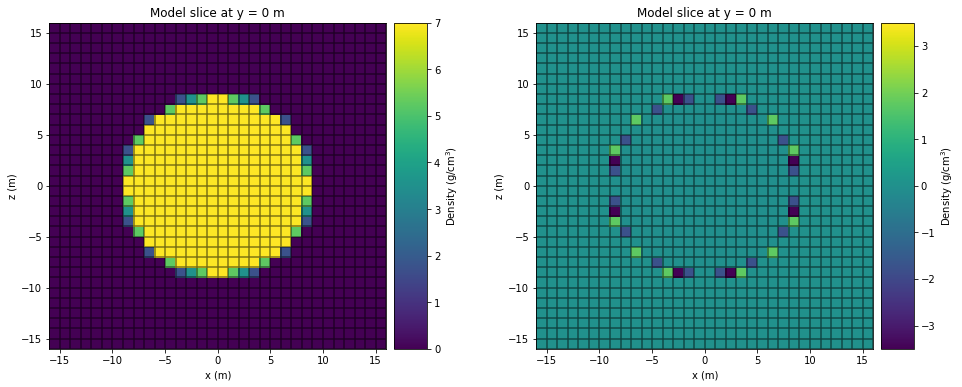

In [14]:
# Downsample high-res model to slightly lower resolution
from SimPEG import maps
dsmap = maps.Mesh2Mesh([fwdmodel2.mesh, fwdmodel3.mesh])
dsmodel = dsmap*fwdmodel3.voxmodel
lrmodel = fwdmodel2.voxmodel
# Each low-res voxel now comprises an average of eight high-res voxels
# Assign an uncertainty on the mean assuming a binomial distribution:  V = p*(1-p)/n
p = dsmodel/dsmodel.max()
dsmodel_std = dsmodel.max()*np.sqrt(p*(1-p)/8.0)

fig6 = plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
fwdmodel2.voxmodel = dsmodel
fwdmodel2.plot_model_slice(ax=ax1)
ax2 = plt.subplot(122)
fwdmodel2.voxmodel = dsmodel - lrmodel
fwdmodel2.plot_model_slice(ax=ax2)
fwdmodel2.voxmodel = lrmodel
plt.show()

## Calculating a discretization uncertainty term by marginalizing out discrete features

For MCMC purposes, we'll want to retain as much speed as possible for the forward-model evaluation, which in many cases will involve regular grids.  What we want, then, is a mathematical framework that tells us how far off $f_{\Delta} \circ g_{\Delta}$ is allowed to be from $f \circ g$, accounting for correlations among observations.

In this context, the closest mathematical statement we can make to saying "the forward model shouldn't depend on the discretization" is to treat the discrete rock properties as probabilistic, and marginalize them out:

$$ P(y|\theta) = \int P(y|g) P(g|\theta) \, d\theta, $$

where $P(y|g) = \delta(y|f(g))$ is the forward model component, and $P(g|\theta)$ replaces the deterministic map $g\!: \Theta \rightarrow \mathcal{G}$.  In general doing this integral analytically won't be possible in a fully general way, but it also may not be necessary; having a basket of techniques we can look at will help, understanding that analytic techniques, Monte Carlo techniques, and low-rank approximations may all be in play.

In the specific case of gravity, the forward model is a linear operator $\mathbf{A}$ over the individual voxels so that $f(g) = \mathbf{A}g$.  This framework should extend to any approach that can be represented as a finite-element or finite-volume method problem.  Under a multivariate Gaussian or GP approximation for the discretized geology $P(g|\theta) \sim \mathcal{N}(g(\theta), \mathbf{G})$, the resulting uncertainty in the fields becomes $\mathbf{AGA}^T$.  This suggests a generalization of the statistical finite element method from Girolami+ (2019), which we may come to eventually.  Since many voxels are involved (and an increasing number of voxels as the resolution is improved), the final error term from any finite-element method is likely to be multivariate Gaussian, even if the individual rock properties aren't.

One way to calculate the integral is to evaluate the discrete pixel properties $\mathbf{g}_\Delta$ not only at the centers of the discrete cells, as is typically done, but at a distribution of points inside each cell.  This amounts to probabilistic anti-aliasing, where we calculate not only an average geology but a variance in the geology across each voxel.  

In [15]:
# Calculate a model error covariance, integrating out random Gaussian perturbations
def data_sys_cov(fwdmodel, model, model_std):
    idx_all = np.arange(len(model_std))
    idx_active = idx_all[model_std > 0]
    dvec = np.zeros(len(model_std))
    # Assume independent variation and accumulate the covariance
    D = [ ]
    for i in idx_active:
        dvec[i] = model_std[i]
        D.append(fwdmodel.fwd.Jvec(model, dvec))
        dvec[i] = 0.0
    D = np.atleast_2d(D)
    C = np.dot(D.T, D)
    print("C.shape =", C.shape)
    return C

# Calculate C and its Cholesky factor, accounting for measurement noise along the diagonal
C = profile_timer(data_sys_cov, fwdmodel2, dsmodel, dsmodel_std)
C += (sigrel*np.std(data0))**2 * np.eye(len(data0))
L = np.linalg.cholesky(C)

C.shape = (100, 100)
data_sys_cov ran in 1.245 sec


run_grid ran in 6.818 sec


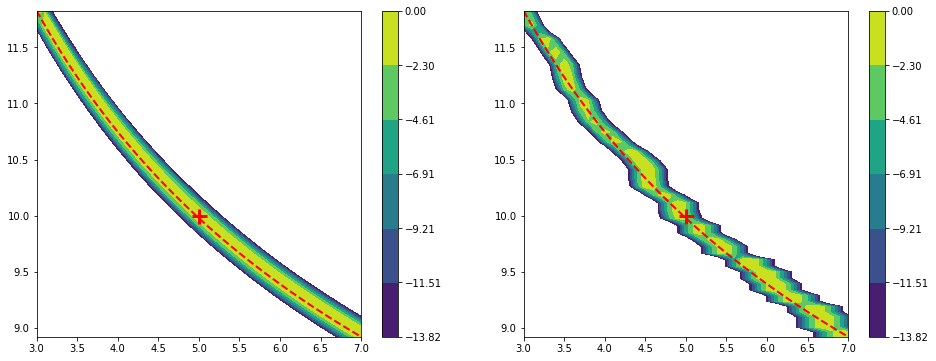

In [16]:
# Redefine the likelihood to account for this model error
def log_likelihood(data, dpred, sigma):
    # Gaussian including model error
    resids = data - dpred
    resids -= resids.mean()
    u = np.linalg.solve(L, resids)
    return -0.5*(np.dot(u, u) + np.log(2*np.pi*np.diag(L)**2).sum())

xg, yg, Lg = profile_timer(run_grid, dsynth, rho_vals, R_vals, fwdmodel2.calc_gravity)
fig10 = plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
show_contours(xg, yg, Lg0, rho_vals, R_vals, rho_0, R_0)
ax2 = plt.subplot(122)
show_contours(xg, yg, Lg, rho_vals, R_vals, rho_0, R_0)
plt.show()

As we can see, this single change hasn't fixed the blocky structure.  We see also, on a second, closer look, that the blocky structure itself shows variation across the posterior:  it's smoother for larger values of the radius.  This is presumably a consequence of the central limit theorem:  larger spheres have more voxels of lower density changing per unit change in radius, which tend to average out, where smaller spheres have fewer pixels of higher density that make more pronounced sudden changes.  Again, this effect is less a function of the grid itself than of the way in which which the geological parameters _project onto_ the grid; the impact of discretization depends on _where you are in parameter space,_ and any correction for these effects therefore has to be appropriately local.

## Parametric anti-aliasing:  smearing geology out by a pixel size

Of course, if the fundamental problem is that the geology is undersampled, there's always the option simply to smear it out to reflect our ignorance.  In other words, we can alter our parametric form for the geology to reflect an approximate anti-aliasing in the map $g_\Delta$:  as a spatial parameter varies across a voxel, the occupancy of the voxel goes smoothly from 0 to 1.  How does the resulting likelihood compare to the analytic likelihood?

DiscreteGravity ran in 0.016 sec
calc_gravity ran in 1.828 sec


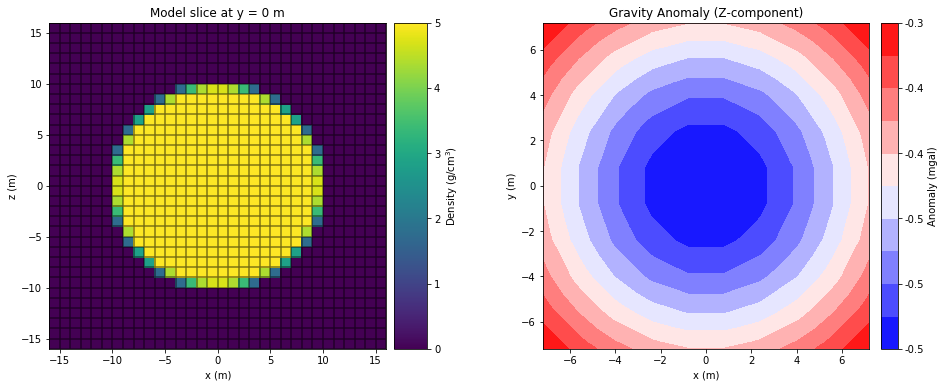

In [17]:
from scipy.special import erf

def log_likelihood(data, dpred, sigma):
    # Back to regular independent Gaussian for now instead
    resids = data - dpred
    resids -= resids.mean()
    return -0.5*np.sum(resids**2/sigma**2 + np.log(2*np.pi*sigma**2))

def smeared_xlty(x, y, h):
    # Returns 1 if x << y, 0 if x >> y, and transitions smoothly over a scale h
    d = (x-y)/h
    result = 1.0*(d < 0)
    # piecewise
    idx = (1.0*np.abs(d) < 1/2)
    result[idx] = -1.0*d[idx] + 0.5
    # error function
    result[idx] = 0.5*(1 + erf(2.15*d[idx]))
    # logistic/GLM
    result[idx] = 0.5*(1 + np.tanh(-2.2*d[idx] - 3.2*(d[idx])**3))
    return result

class SmearedSphereGfunc:
    # Parametrically anti-aliased geology
    
    def __init__(self, h):
        self.h = h
        
    def __call__(self, r, R, rho):
        return rho * smeared_xlty(np.sqrt(np.sum(r**2, axis=1)), R, self.h)

# New forward model
fwdmodel6 = profile_timer(DiscreteGravity, fwdmodel2.mesh, survey_10x10, SmearedSphereGfunc(1.0))
data6 = profile_timer(fwdmodel6.calc_gravity, R_0, rho_0)
fig4 = plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
fwdmodel6.plot_model_slice(ax=ax1)
ax2 = plt.subplot(122)
fwdmodel6.plot_gravity(ax=ax2)
plt.show()

run_grid ran in 6.979 sec
run_grid ran in 0.127 sec


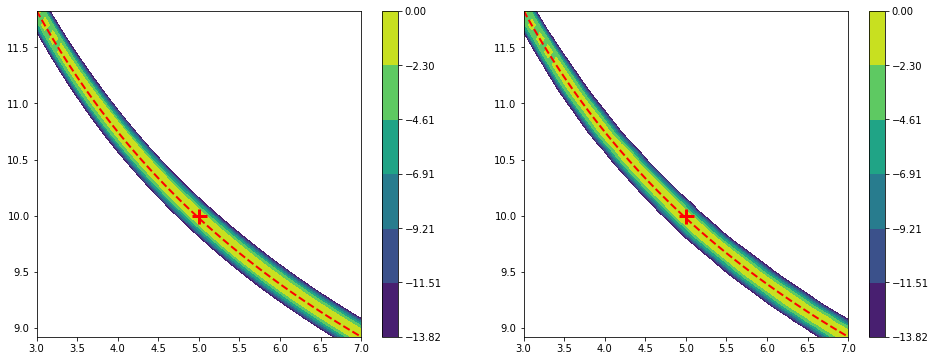

In [18]:
data0 = analytic_forward_gravity_sphere(survey_10x10, R_0, rho_0, r0=(0,0,0))[2]
sigrel = 0.1
sigdata = sigrel*np.std(data0)
epsilon = sigdata*np.random.normal(size=data0.shape)
dsynth = data0 + epsilon

xg, yg, Lg = profile_timer(run_grid, dsynth, rho_vals, R_vals, fwdmodel6.calc_gravity)
xg, yg, Lg0 = profile_timer(run_grid, dsynth, rho_vals, R_vals,
                            lambda R, rho: analytic_forward_gravity_sphere(survey_10x10, R, rho, r0=(0,0,0))[2])
fig10 = plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
show_contours(xg, yg, Lg0, rho_vals, R_vals, rho_0, R_0)
ax2 = plt.subplot(122)
show_contours(xg, yg, Lg, rho_vals, R_vals, rho_0, R_0)
plt.show()

The result is surprisingly close!  What happens if we go back to our lowest-resolution mesh?

DiscreteGravity ran in 0.005 sec
calc_gravity ran in 0.244 sec


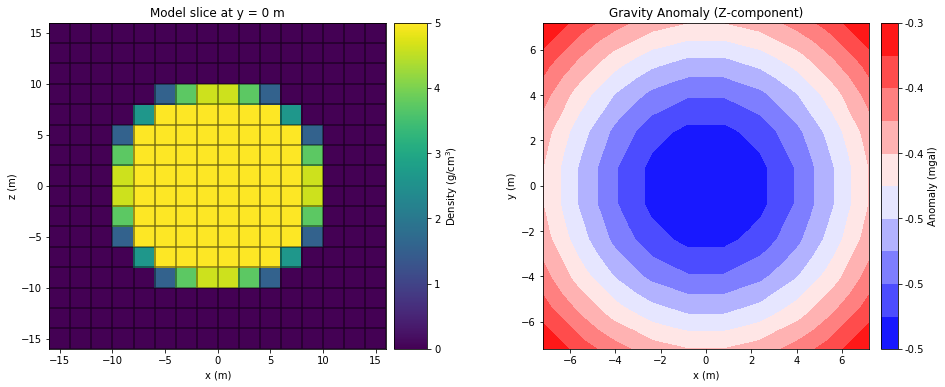

In [19]:
fwdmodel7 = profile_timer(DiscreteGravity, fwdmodel.mesh, survey_10x10, SmearedSphereGfunc(2.0))
data7 = profile_timer(fwdmodel7.calc_gravity, R_0, rho_0)
fig11 = plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
fwdmodel7.plot_model_slice(ax=ax1)
ax2 = plt.subplot(122)
fwdmodel7.plot_gravity(ax=ax2)
plt.show()

run_grid ran in 1.259 sec


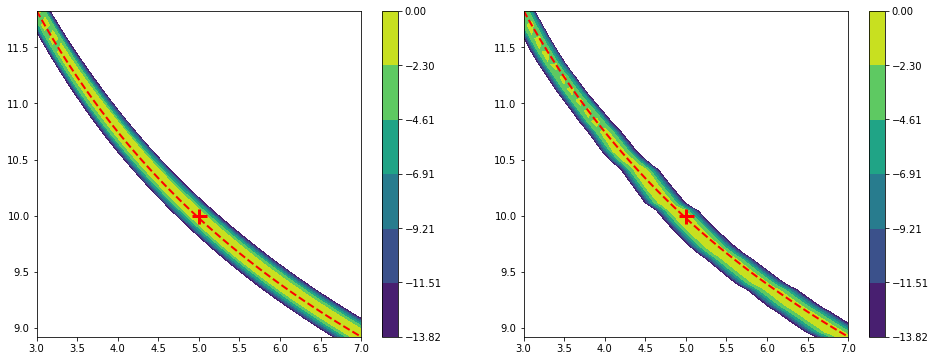

In [20]:
xg, yg, Lg = profile_timer(run_grid, dsynth, rho_vals, R_vals, fwdmodel7.calc_gravity)
fig12 = plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
show_contours(xg, yg, Lg0, rho_vals, R_vals, rho_0, R_0)
ax2 = plt.subplot(122)
show_contours(xg, yg, Lg, rho_vals, R_vals, rho_0, R_0)
plt.show()

Something that was previously impassable now looks quite close to the truth.  And if we reduce the noise variance?

DiscreteGravity ran in 0.004 sec
calc_gravity ran in 0.231 sec
run_grid ran in 1.223 sec
run_grid ran in 0.123 sec


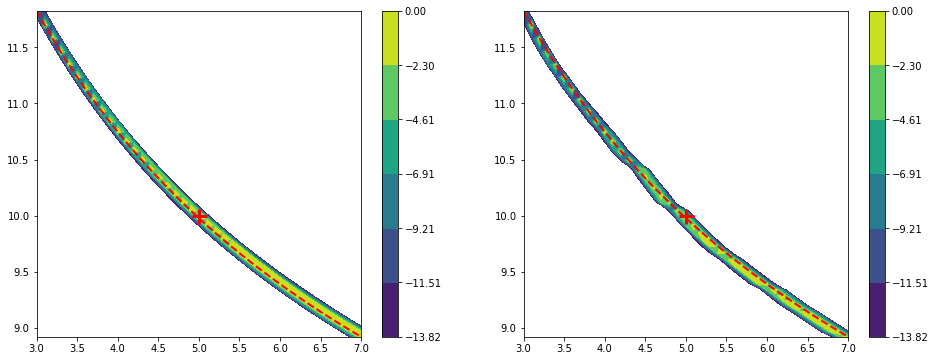

In [21]:
data0 = analytic_forward_gravity_sphere(survey_10x10, R_0, rho_0, r0=(0,0,0))[2]
sigrel = 0.05
sigdata = sigrel*np.std(data0)
epsilon = sigdata*np.random.normal(size=data0.shape)
dsynth = data0 + epsilon

fwdmodel8 = profile_timer(DiscreteGravity, fwdmodel.mesh, survey_10x10, SmearedSphereGfunc(2.0))
data8 = profile_timer(fwdmodel8.calc_gravity, R_0, rho_0)
xg, yg, Lg = profile_timer(run_grid, dsynth, rho_vals, R_vals, fwdmodel8.calc_gravity)
xg, yg, Lg0 = profile_timer(run_grid, dsynth, rho_vals, R_vals,
                            lambda R, rho: analytic_forward_gravity_sphere(survey_10x10, R, rho, r0=(0,0,0))[2])
fig10 = plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
show_contours(xg, yg, Lg0, rho_vals, R_vals, rho_0, R_0)
ax2 = plt.subplot(122)
show_contours(xg, yg, Lg, rho_vals, R_vals, rho_0, R_0)
plt.show()

Maybe not perfect, but certainly much better than before.  The essential features that impact the inference, such as the width and extent of the posterior, appear to be preserved faithfully; there seems to be a small bias in the posterior vis-a-vis the true parameters as well.

The mere device of smearing the likelihood out in space isn't perfect or rigorous, in that it doesn't take into account the uncertainty in partial volume.  However, it turns out that if done at the discretization scale, smearing before discretization turns out to be a very good approximation to calculating the true partial volume (within a few percent), as I'll show below.  The results also aren't very sensitive to the parametric form of the smoothing function, i.e. to the detailed distributions of rock properties in individual partial voxels:  for example, we see similar results from linear and from softmax interpolation.  This may make sense also from a central limit theorem perspective, since there are hundreds of voxels being averaged over.  The most important change is that the discretized model has now become a smooth function of the geological parameters -- the optimal parameters for that function being fixed by moment matching to the distribution of partial volume.  This could in principle be done numerically using any other anti-aliasing approach, but it would be much more expensive than doing it this way.

The good news is that some geological modeling engines already anti-alias their block models this way.  For example, GemPy allows the user to smooth out an infinitely thin contact and give it a finite width, using partitions of unity like the one I used above.  Treating this explicitly as an anti-aliasing technique to approximate the infinite-resolution posterior, however, gives us a preferred criterion for the finite width of any unresolved feature.

One downside of this solution is that it needs to be implemented at the level of parametrizing geology.  Nyquist's theorem wins again:  we didn't get here by post-processing undersampled discretizations, and indeed if the discretization is undersampled then critical information has already been lost.  So if we're going to use this solution, we need to open the box.  Another potential downside is that approximating rock properties by a voxel average may not work so well for complex nonlinear sensors.  For linear sensors, though, it should be fine.

## A numerical experiment to validate the parametric anti-aliasing approximation

The following script tests the functional form of three approximations for anti-aliasing:  linear interpolation, softmax, and a Gaussian process regression.  The target is a numerical integration of the fraction of volume of a unit cube, bounded by a plane running through a point $\mathbf{r_0}$ within the cube and unit normal vector $\mathbf{n}$.  Predictions using the single feature $\mathbf{r_0 \cdot n}$ already give good results:

X.shape, Y.shape = (1000, 3) (1000, 1)
Fitting GP...
Learned kernel: Matern(length_scale=[4.74, 15.1, 31], nu=1.5) + WhiteKernel(noise_level=1e-05)
Log-marginal-likelihood: 4142.346
fit ran in 2.143 sec
resids(piecewise) mean, std = 9.45e-05, 0.0189
resids(GLM)       mean, std = -1.9e-05, 0.0108
resids(GP)        mean, std = 8.26e-05, 0.00315


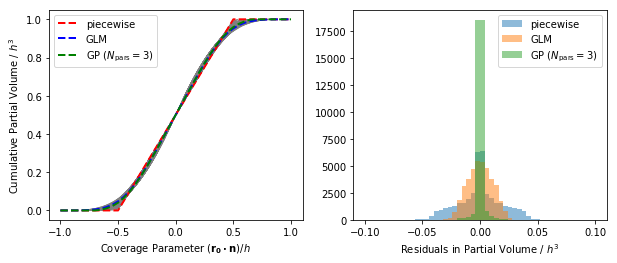

In [22]:
from antialias import compare_antialiasing
compare_antialiasing(N_features_gp=3)

This turned out to be a much better approximation than I had thought it would be.  A 2% correction in the mean on a statistically large, but volumetrically small, number of voxels will contribute sub-dominant error for most realistic sensors or surveys.  For added precision, the Gaussian process model can also use up to two additional features that capture the orientation of $\mathbf{n}$ with respect to the cube faces.  Use of these two additional features can deliver 0.3% RMS precision on the fractional volume of a voxel.

Of course, there may be datasets or survey designs that test even this level of accuracy, so that the error is no longer sub-dominant.  At that point, either a higher-resolution mesh or a model error term like the ones I tried to construct above may come into play.  The next step will involve coming up with a numerical criterion to help us judge when to do this.

## How to know when a finer grid is needed

We seek a criterion that tells us when a discretized likelihood is close enough to the true likelihood as to leave the inference unchanged.  This may be challenging to determine in cases where we don't have access to the true likelihood, as with the analytic solution for the uniform-density sphere.  One way to formulate it is to make the likelihood independent of discretization --- so that there exists some discretization scale $h$ beneath which any two discretizations $\Delta_k$ and $\Delta_{k'}$ give nearly the same answer,

$$\log \mathcal{L}_{\Delta_k} - \log \mathcal{L}_{\Delta_{k'}} < \epsilon$$

with $\epsilon \ll 1$, uniformly over some area of estimation.  If this criterion holds, then the inaccuracies will at least not greatly impede MCMC sampling as the error on the Metropolis ratio is also bounded.  It translates to specific properties of the functions being probed; in the case of gravity, it requires that the infinite-resolution composition of geology and forward model $f \circ g$ be Riemann-integrable.  It is also natural in that it incorporates any aspects of the dataset that would allow resolution into finer elements.

However, this exact limiting behavior is also probably too restrictive to give good performance in practical problems.  It's not hard to imagine the numerical value of the likelihood differing from the infinite-resolution case by more than $\epsilon$ without materially affecting the inference.  In these cases, a numerical threshold also doesn't describe _how_ the posteriors are different; it doesn't capture the blockiness of the aliased posterior that's our main obstacle to sampling.

The sensitivity of the discrete likelihood $\mathcal{L}$ to rock properties $g$ under some perturbation $\delta g$ will look like

$$ \log \mathcal{L} = \log \mathcal{L}_0 + \sum_{i,j}
    \frac{\partial (\log \mathcal{L})}{\partial f_i} \frac{\partial f_i}{\partial g_j}
       \, \delta g_j + O(\delta g_j^2) $$

where $f = \{ f_1, f_2, \ldots, f_{m_k} \}$ is the forward-modeled likelihood mean, and $g = \{ g_1, g_2, \ldots, g_{n_k} \}$ are the rock properties at partition stage $k$.  There are already examples in geophysics of choosing partitions $\Delta_k$ that equalize the sensor response $\partial f_i/\partial g_j$ across voxels -- for example, increasing voxel size with increasing depth as the sensitivity drops off with inverse depth squared.  The slope $\partial (\log \mathcal{L})/\partial f_i$ also matters -- the structure of the width and tails of the chosen error distribution.

In an interpretable model, however, $\delta g = \nabla_\theta g \cdot \delta \theta$.  If rock properties are assigned to voxels by evaluating the parametric geology at a point (usually the center of the voxel), this creates problems for geologies with step discontinuities in rock properties.  Along directions $\delta_\theta$ corresponding to spatially aliased parameters (such as our sphere's radius, rather than its density), $\nabla_\theta g$ is zero almost everywhere except at discontinuities, where it doesn't exist.  The step-function behavior is then transformed through the sensor function and raised to a high power when compared to data as part of the likelihood.  For example, if the error in the fields goes like some power $h^\alpha$ of some element size $h$, as it does for many different numerical schemes, then the error in an iid Gaussian likelihood will go like $N h^{2\alpha}/\sigma_y^2$ if there are $N$ data points with noise variance $\sigma_y^2$.

The reason the spatial anti-aliasing works so well for gravity is that the action of the sensor is a spatial convolution:  if $g_j$ equals the spatial average of $g$ over voxel $j$, the contribution to uncertainty from undersampled geology goes to zero, and the spatial variation of $f_i$ is modest except for voxels near the surface.  For differential or non-linear sensors, we probably need to be more careful!

If anti-aliasing is introduced, then a smooth anti-aliasing kernel will produce a smooth $\nabla_\theta g$.  We can consider anti-aliasing scales much smaller than a discretization scale to reproduce the limiting step-function behavior.  There are two dangers.  If the anti-aliasing scale is too small, the likelihood will take on a terraced appearance; this could be recognized by looking for voxels where the Fisher information $h^2 \nabla^2_\theta (\log \mathcal{L})$ is small.  If the anti-aliasing scale is too large, the field calculations will become biased, which should show itself in a shift in the spatial position of the maximum likelihood.  This is probably the sort of shortcoming that could be overcome with an extra model error term or Richardson extrapolation.

The Fisher information over a voxel, decomposing via the chain rule into its various parts, is

$$ h^2 \left( \frac{\partial^2 (\log \mathcal{L})}{\partial f_i^2} \frac{\partial f_i}{\partial g_j} \frac{\partial g_j}{\partial \theta} +
\frac{\partial (\log \mathcal{L})}{\partial f_i} \frac{\partial^2 f_i}{\partial g_j^2} \frac{\partial g_j}{\partial \theta} +
\frac{\partial (\log \mathcal{L})}{\partial f_i} \frac{\partial f_i}{\partial g_j} \frac{\partial^2 g_j}{\partial \theta^2} \right)$$

For gravity under a Gaussian likelihood, the action $f(g) = \mathbf{A}g$ is linear so that the Hessian of the likelihood simplifies as follows:

$$ \log \mathcal{L} = -\frac{1}{2}(\mathbf{y}-\mathbf{A}g(\theta))^T \mathbf{C}^{-1} (\mathbf{y}-\mathbf{A}g(\theta)) - \frac{1}{2} \log |2 \pi \mathbf{C}| $$

$$ \nabla_\theta (\log \mathcal{L}) = -\frac{1}{2} (\mathbf{y}-\mathbf{A}g(\theta))^T \mathbf{C}^{-1} \mathbf{A} \nabla_\theta g + \mathrm{transpose}$$

$$ \nabla^2_\theta (\log \mathcal{L}) = -\frac{1}{2} \left( \nabla_\theta g \mathbf{A} \mathbf{C}^{-1} \mathbf{A} \nabla_\theta g + (\mathbf{y}-\mathbf{A}g(\theta)^T \mathbf{C}^{-1} \mathbf{A} \nabla^2_\theta g \right) + \mathrm{transpose}$$

where $C$ is the covariance matrix of the data, equal to $\mathrm{diag} (\sigma^{-2})$ for an iid Gaussian likelihood.

Calculating this quantity for every voxel in the inversion is both expensive and pointless, as even in a well-sampled model the information will concentrate in the interface voxels where $\nabla_\theta g$ is nonzero.  Calculating the Fisher information over the interface voxels, though, and only for parameters $\theta$ related to spatial sampling, should be feasible and could provide a helpful diagnostic.  Since $\mathbf{A}$ and $\mathbf{C}$ are known constants, the main overhead here is in calculating $\nabla_\theta g$ and $\nabla^2_\theta g$; this could be done analytically for parametric forms, or using auto-differentiation frameworks such as TensorFlow or PyTorch for more complicated geologies.